In [12]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
from astropy.io import fits
import fitsio
from scipy import stats
import sys, os, warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, train_test_split, KFold

# Load and Prepare Data

In [21]:
cat = Table(fitsio.read('/global/cfs/cdirs/desi/spectro/redux/daily/exposures-daily.fits'))
mask = cat['SURVEY']=='main'
mask &= cat['PROGRAM']=='bright'
mask &= cat['EFFTIME_ETC']>100
mask &= cat['EFFTIME_SPEC']>100
mask &= cat['MJD'] != 0
cat = cat[mask]

### Eliminate pairs of data that are across large time gaps

In [22]:
# We create an array that holds the time gaps between the current data point and the previous
time_gaps = []
for i in range(1, len(cat['MJD']+1)): # remove MJD = 0
    time_gap = cat['MJD'][i] - cat['MJD'][i-1]
    time_gaps.append(time_gap) 

# only add data to cor_ratio if the time gap between the points is < gap

gap = 2/24 #2 hours

# "cor" = corrected by dividing by the previous value
cor_ratio = []
cor_curr = []
cor_prev = []
for i in range(1,len(time_gaps)):
    if time_gaps[i] < gap:
        cor_ratio.append((cat['EFFTIME_SPEC'][i]/cat['EFFTIME_ETC'][i])/(cat['EFFTIME_SPEC'][i-1]/cat['EFFTIME_ETC'][i-1]))
        cor_curr.append(cat['EFFTIME_SPEC'][i]/cat['EFFTIME_ETC'][i])
        cor_prev.append(cat['EFFTIME_SPEC'][i-1]/cat['EFFTIME_ETC'][i-1])


# Find Optimal Limits on Correction

In [23]:
# function that counts the number of data points outside the 0.85-1.15 range in arr
def count_highs(arr):
    return (np.array(arr) > 1.15).sum()/len(arr)

def count_lows(arr):
    return (np.array(arr) < 0.85).sum()/len(arr)

# "lim" = limited correction     
# lowsandhighs is a 2d array that will store pairs of the form [data < 0.85, data > 1.15] for each set of corrections ([min, max])
lowsandhighs =[]
corrections = []

# to find optimal lower + upper limit
for i in np.linspace(0, 1, 100):
    for j in np.linspace(1, 2, 100):
        lim_min = i
        lim_max = j
        lim_prev = np.clip(cor_prev, lim_min, lim_max) # clip all the previous points (divisors) to desired range
        lim_ratio = cor_curr/lim_prev
        lowsandhighs.append([count_highs(lim_ratio),count_lows(lim_ratio)])
        corrections.append([lim_min,lim_max])

In [24]:
# now we find the corresponding min and max correction to the data that had the smallest combined sum of highs and lows
summed_lowsandhighs = []
for pair in lowsandhighs:
    summed_lowsandhighs.append(pair[0] + pair[1])

opt_idx = summed_lowsandhighs.index(min(summed_lowsandhighs))

print(lowsandhighs[opt_idx])
print(corrections[opt_idx])

[0.062325581395348835, 0.044651162790697675]
[1.0, 1.7676767676767677]


In [25]:
# apply the optimized limits on corrections

lim_prev = np.clip(cor_prev, corrections[opt_idx][0], corrections[opt_idx][1]) # clip all the previous points (divisors) to desired range
lim_ratio = cor_curr/lim_prev


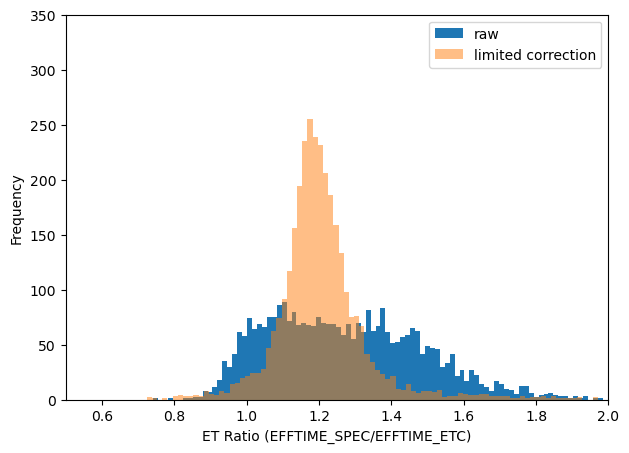

In [26]:
plt.figure(figsize=(7,5))

plt.hist(cor_curr, bins = 100);
plt.hist(lim_ratio*1.2, bins = 100,alpha = 0.5);
plt.legend(['raw', 'limited correction'])
plt.ylim(0,350)
plt.xlim(0.5,2)
plt.ylabel('Frequency')
plt.xlabel('ET Ratio (EFFTIME_SPEC/EFFTIME_ETC)')
plt.show()

In [27]:

def show_stats(arr, name): # takes in the array and the name of the data
    print('Statistics for', name)
    print('Fraction under 0.85:', count_lows(arr))
    print('Fraction over 1.15:', count_highs(arr))
    print('Median Absolute Deviation:', stats.median_abs_deviation(arr))
    print('Standard Deviation:', np.std(arr))
    print('-------------------------------')
    etratio_actu=cor_curr
    outliersraw = count_lows(etratio_actu)+count_highs(etratio_actu)
    outliersarr = count_lows(arr) + count_highs(arr)
    print('Reduction in underexposed <0.85 from Raw Data: ', 1-(count_lows(arr)/count_lows(etratio_actu)))
    print('Reduction in outliers from Raw Data:', outliersraw - outliersarr, "(", (outliersraw-outliersarr)/outliersraw*100,"% )")
    print('Reduction in MAD from Raw Data:', stats.median_abs_deviation(etratio_actu) - stats.median_abs_deviation(arr), "(", (stats.median_abs_deviation(etratio_actu) - stats.median_abs_deviation(arr))/stats.median_abs_deviation(etratio_actu) *100,"% )")
    print('Reduction in SD from Raw Data:', np.std(etratio_actu) - np.std(arr), "(", (np.std(etratio_actu) - np.std(arr))/np.std(etratio_actu) *100,"% )")

    print('-------------------------------')


In [28]:
show_stats(cat['EFFTIME_SPEC']/cat['EFFTIME_ETC'], "Raw Data")
print()
show_stats(cor_ratio, "Unlimited Correction Data")
print()
show_stats(lim_ratio, "Limited Correction Data")


Statistics for Raw Data
Fraction under 0.85: 0.005737508964857758
Fraction over 1.15: 0.5916806120009562
Median Absolute Deviation: 0.1574768225110421
Standard Deviation: 0.2184885148130682
-------------------------------
Reduction in underexposed <0.85 from Raw Data:  -3.6258666029165667
Reduction in outliers from Raw Data: 0.06552761546829444 ( 9.884310565259568 % )
Reduction in MAD from Raw Data: 0.0020910803875131556 ( 1.3104642910814919 % )
Reduction in SD from Raw Data: -0.0040684673208434 ( -1.8974286072718685 % )
-------------------------------

Statistics for Unlimited Correction Data
Fraction under 0.85: 0.0462015503875969
Fraction over 1.15: 0.07348837209302325
Median Absolute Deviation: 0.04464509428383545
Standard Deviation: 0.1214140449693553
-------------------------------
Reduction in underexposed <0.85 from Raw Data:  -36.25
Reduction in outliers from Raw Data: 0.5432558139534883 ( 81.94574368568756 % )
Reduction in MAD from Raw Data: 0.11492280861471982 ( 72.021256485